In [81]:
from pandas_datareader import data
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [74]:
# Establishing Dates
start = "2016-06-01"
end = datetime.today().strftime('%Y-%m-%d')

# Establishing Assets
assets = ['BND', 'VNQ', 'VTV', 'VWINX', 'VTXVX']

#252 trading days in a year
N = 252

#2% risk free rate
rf =0.02

# Creating an empty dataframe
df_prices = pd.DataFrame()

# Getting the "Adj Close" data from Yahoo Finance by defining a function
# This function lists the price data as daily percent change 
def YahooData(dataframe, assets_list, start_date, end_date):
    for i in assets_list:
        dataframe[i] = data.DataReader(i, data_source = "yahoo", start=start_date, end=end_date)['Adj Close']
    return dataframe

# Running the function that we just made and saving the results to the DataFrame
df = YahooData(df_prices, assets, start, end)

# Calculating Log Return
df = np.log(df/df.shift(1))

# Dropping the first row because it's N/A
df = df.dropna()

# Viewing df head
df


,BND,VNQ,VTV,VWINX,VTXVX
Date,,,,,
2016-06-02,0.001934,0.005122,0.002711,0.002335,0.001361
2016-06-03,0.006259,0.004031,-0.003183,0.004266,0.003396
2016-06-06,-0.001561,-0.007721,0.006825,0.000387,0.002032
2016-06-07,0.000120,0.006063,0.002811,0.001932,0.002703
2016-06-08,0.001201,0.006380,0.003036,0.001929,0.002695
...,...,...,...,...,...
2021-05-28,-0.000117,0.006025,0.001430,0.000680,0.001236
2021-06-01,-0.000070,0.017861,0.001000,0.000340,0.001234
2021-06-02,0.001057,0.011635,0.002495,0.002037,0.000617


In [75]:
# Creating 10000 random simulations of each portfolio weight configuration
num_runs = 10000 # number of rows/iterations

# Creating a Matrix with 10000 rows, with each row representing a random portfolio:
    #first 3 columns are Mean Returns, Standard Deviation, and Sortino Ratio
    # remaining columns are each assets random weight within that random portfolio
result = np.zeros((num_runs,(len(assets)+5)))
result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
#df = df.copy()
for i in range(num_runs):
    
    # randomized weights
    weights = np.array(np.random.random(len(assets))) 
    #Rebalance w/ constraints (SUM of all weights CANNOT BE > 1)
    weights = weights/np.sum(weights)
    
    # daily return of the portfolio based on a given set of weights
    df['portfolio_ret'] = df.iloc[:,0]*weights[0]+df.iloc[:,1]*weights[1]+df.iloc[:,2]*weights[2]
    
    # Calculating Mean
    E = df['portfolio_ret'].mean()
    # Annualizing Mean
    E_AN = E * N
    
    # Calculating Downside Standard Deviation
    mean = E * N -rf
    std_neg = df['portfolio_ret'][df['portfolio_ret']<0].std()*np.sqrt(N)
    
    
    # Calculating Upside Standard Deviation
    std_pos = df['portfolio_ret'][df['portfolio_ret']>=0].std()*np.sqrt(N)
    
    # Calculating Volatility Skewness
    VS = std_pos/std_neg
    
    # Sortino
    Sortino = mean/std_neg
   
    # Populating the 'result' array with the required values: Mean, SD, Sharpe followed by the weights                   
    result[i,0] = E_AN
    result[i,1] = std_neg
    result[i,2] = std_pos
    result[i,3] = VS
    result[i,4] = Sortino
    
    for j in range(len(assets)):
        result[i,j+5]= weights[j]

In [77]:
# Converting 'result' into a DataFrame

columns = ['Mean','Downside SD', 'Upside SD', 'Volatility Skewness', 'Sortino'] + assets

result = pd.DataFrame(result,columns=columns)
result

,Mean,Downside SD,Upside SD,Volatility Skewness,Sortino,BND,VNQ,VTV,VWINX,VTXVX
0,0.051016,0.086791,0.060936,0.702104,0.357362,0.209067,0.243614,0.187939,0.204959,0.154421
1,0.039893,0.083139,0.057111,0.686930,0.239279,0.259867,0.354620,0.017576,0.030175,0.337761
2,0.050717,0.081365,0.058310,0.716647,0.377523,0.112127,0.163582,0.261683,0.193138,0.269470
3,0.060932,0.097872,0.067733,0.692060,0.418216,0.377654,0.258965,0.211585,0.118643,0.033153
4,0.037864,0.067250,0.047780,0.710488,0.265636,0.033725,0.171958,0.176662,0.242255,0.375401
...,...,...,...,...,...,...,...,...,...,...
9995,0.054807,0.101031,0.070972,0.702477,0.344516,0.125988,0.310783,0.196321,0.213815,0.153094
9996,0.052698,0.079002,0.057491,0.727719,0.413891,0.114269,0.110329,0.310409,0.006386,0.458607
9997,0.071895,0.134393,0.093814,0.698055,0.386142,0.223569,0.440791,0.221334,0.060022,0.054284
9998,0.065970,0.113424,0.081397,0.717632,0.405294,0.001249,0.241219,0.359854,0.019860,0.377819


In [78]:
Max_Sortino = result.iloc[result['Sortino'].idxmax()]
Max_Sortino

Mean                   0.082106
Downside SD            0.102428
Upside SD              0.074341
Volatility Skewness    0.725787
Sortino                0.606333
BND                    0.460891
VNQ                    0.013508
VTV                    0.510877
VWINX                  0.005831
VTXVX                  0.008892
Name: 3785, dtype: float64

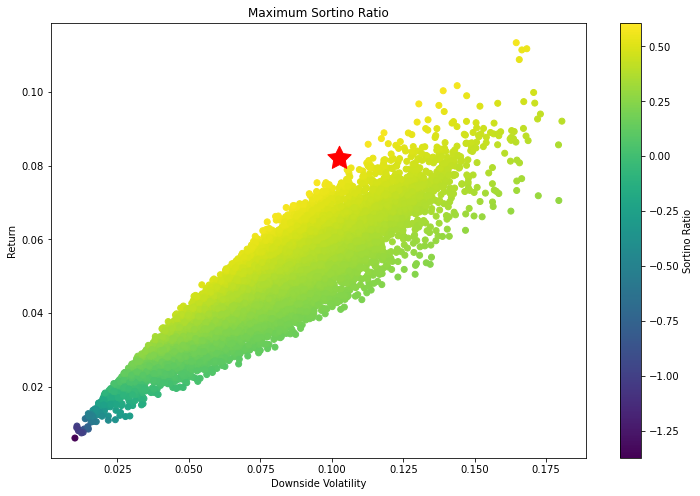

In [80]:
plt.figure(figsize=(12,8))
plt.scatter(x=result['Downside SD'],y=result['Mean'],c=result['Sortino'],cmap='viridis')
plt.colorbar(label='Sortino Ratio')
plt.xlabel('Downside Volatility')
plt.ylabel('Return')

plt.title('Maximum Sortino Ratio')
#Plot a red star to highlight position of the portfolio with highest Sortino Ratio
plt.scatter(Max_Sortino[1],Max_Sortino[0],marker=(5,1,0),color='r',s=600)

plt.show()